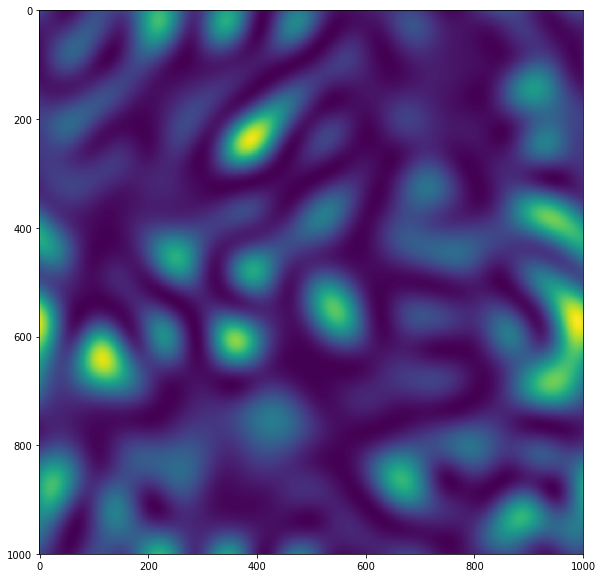

In [292]:
import numpy as np
import time
from matplotlib import pyplot as plt

side = 1000
image = np.zeros([side,side])
speckleSize = 100
xPhasors = int(np.round(side/speckleSize))
yPhasors = int(np.round(side/speckleSize))
phasor = np.zeros([side,side],dtype = complex)

noiseSize = 2

def poissonNoise(noiseSize,side):
    poisson = np.random.poisson(noiseSize,size=[side,side]) 
    poisson = poisson/np.max(poisson)
    return poisson

for i in range(xPhasors):
    for j in range(yPhasors):
        phase = np.random.random()*2*np.pi*1j
        phasor[i,j] = np.exp(phase)


speckle = np.fft.fft2(phasor)
speckle = [np.abs(elt)**2 for elt in speckle]
speckle /= np.max(speckle)

poisson = poissonNoise(noiseSize,side)
#speckle += poisson

#Add 2 uncorrelated patterns together to get 0.5 contrast
#Simulate charge cloud: we need better resolution than the detector size
# do for example 1000x1000 and then finally get 200x200 when I digitize.
# Speckle size should also be bigger than the 5x5 detector size.

plt.figure(figsize=[10,10])
plt.imshow(speckle)

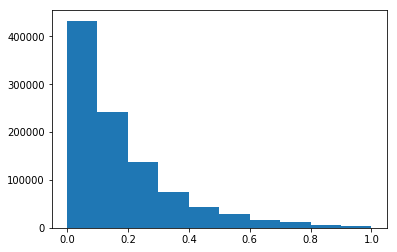

In [271]:
plt.hist(speckle.flatten());

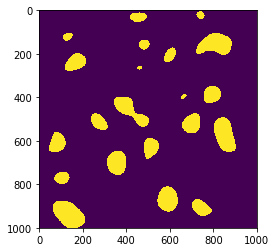

In [272]:
plt.imshow(speckle > 0.4)

In [277]:
#https://math.stackexchange.com/questions/316175/probability-to-choose-specific-item-in-a-weighted-sampling-without-replacement#320640
from ast import literal_eval as make_tuple
from scipy import ndimage
nPhotons = 100

speckleLabels = [["({},{})".format(j,i) for i in range(np.shape(speckle)[0])] for j in range(np.shape(speckle)[1])]
speckleLabels = [elt for row in speckleLabels for elt in row] # Flatten
flatSpeckle = np.reshape(speckle,np.shape(speckle)[0]*np.shape(speckle)[1]) # Flatten
flatSpeckle /= np.sum(flatSpeckle) # Normalize
choices = np.random.choice(speckleLabels,nPhotons, p=flatSpeckle)

photons = np.zeros(np.shape(speckle))
for elt in choices:
    tup = make_tuple(elt)
    photons[tup[0],tup[1]] = 1 # Or assign some number to phton to electron-photon conversion. So use 
    
# 1 photon 8keV gives 3.6eV/electron (say 2000), add losses later

photonsGaus = ndimage.filters.gaussian_filter(photons,10)

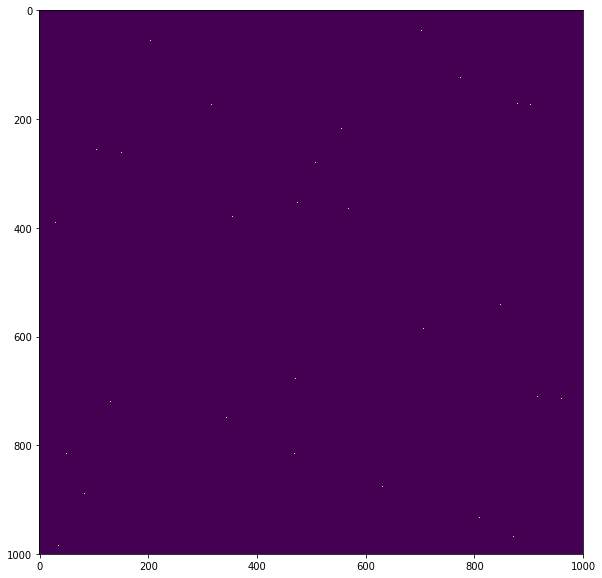

In [278]:
plt.figure(figsize=[10,10])
plt.imshow(photons)

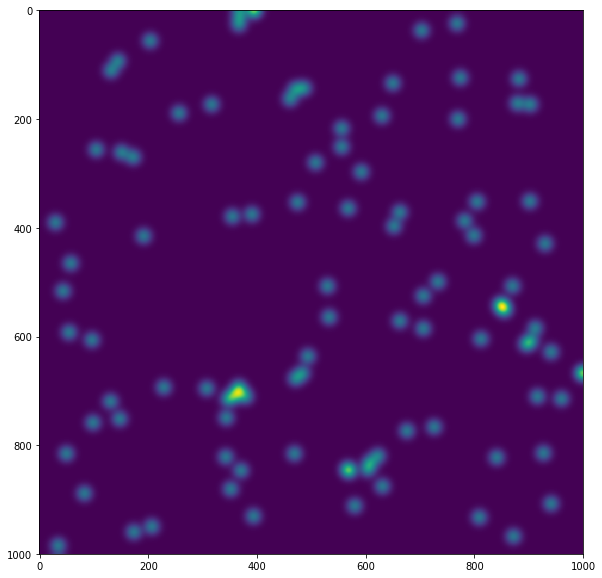

In [279]:
plt.figure(figsize=[10,10])
plt.imshow(photonsGaus)

In [281]:
np.sum(photonsGaus)

100.0

In [282]:
# Charge map
def downsize(img,compression):
    newSide = int(np.shape(img)[0]*compression)
    mag = int(1/compression) 
    newImg = np.zeros((newSide,newSide))
    for i in range(newSide):
        for j in range(newSide):
            newImg[i,j] = np.sum(img[i*mag:i*mag+mag,j*mag:j*mag+mag])
    return newImg

charge = downsize(photonsGaus,0.1)

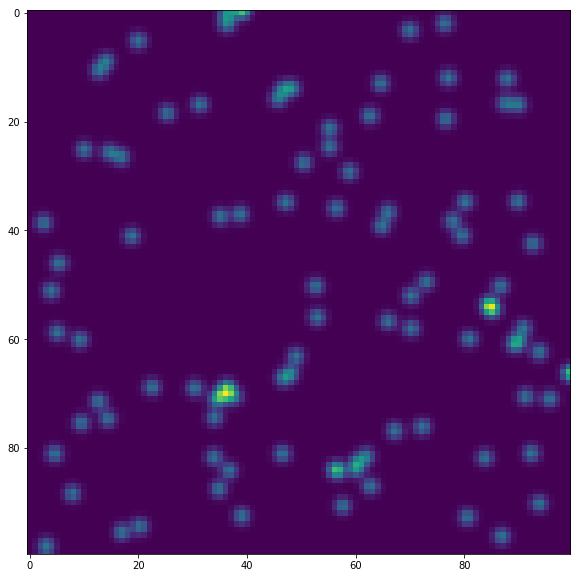

In [283]:
plt.figure(figsize=[10,10])
plt.imshow(charge)

In [ ]:
# Plot hist of above as function of Gaussian size
# Add Gaussian readout noise, about 5-10/pixel (play)

In [284]:
# sum of pixels for 1 photon should be around 200

# Add Gaussian noise to each pixel, sigma \pm 3



lam = 0.1
poisson = poissonNoise(lam,np.shape(charge)[0])/np.max(poisson)
NSR = 0.5 
peak = np.max(charge)*NSR
charge += poisson*peak

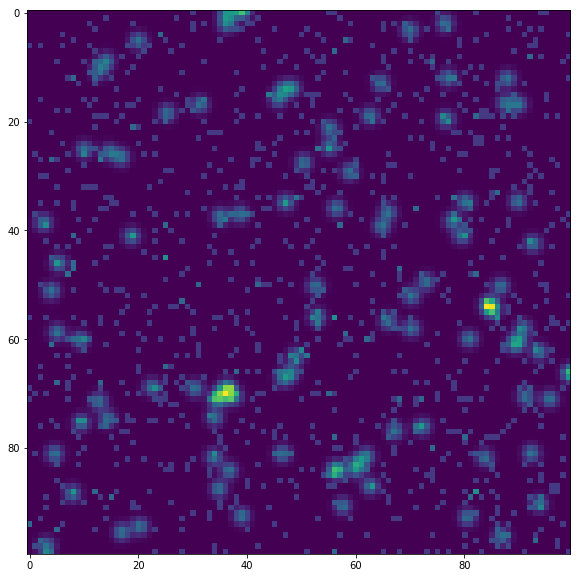

In [285]:
plt.figure(figsize=[10,10])
plt.imshow(charge)

In [286]:
# Droplet algorithm
charge -= np.mean(charge)
ADUThresh = 0
labeled, nr_objects = ndimage.label(charge > ADUThresh)

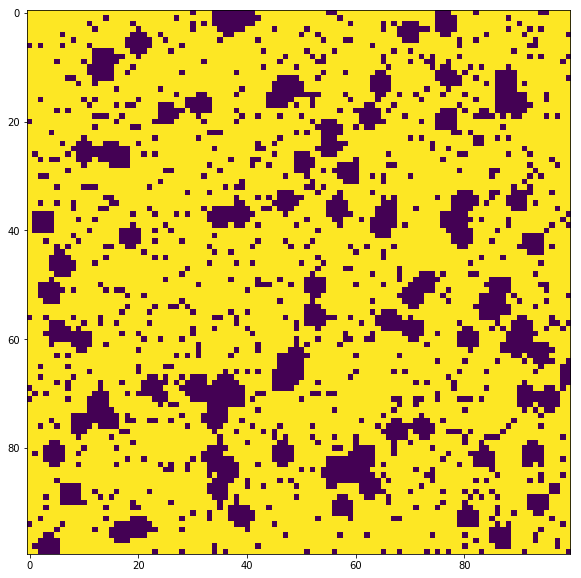

In [287]:
plt.figure(figsize=[10,10])
plt.imshow(labeled == 0)

In [288]:
dropletSignal = np.zeros(nr_objects+1)
for i in range(0,nr_objects+1):
    mask = labeled == i
    dropletSignal[i] = np.sum(np.multiply(mask,charge))

minSignal = 0.5
dropletSignal = np.multiply(dropletSignal,dropletSignal > minSignal)
nonzeros = [elt for elt in dropletSignal if elt != 0]

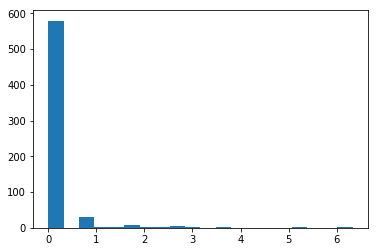

In [289]:
plt.hist(dropletSignal,20);

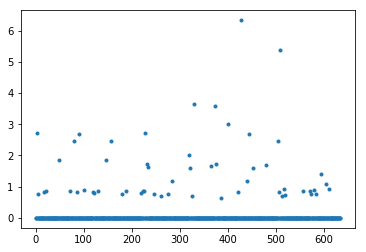

In [290]:
plt.plot(dropletSignal,'.')

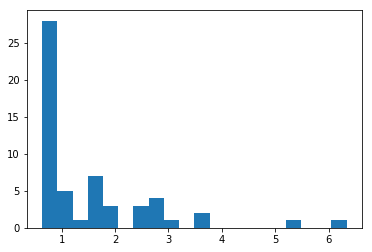

In [291]:
plt.hist(nonzeros,20);

In [ ]:
# Repeat 100 times to collect more photons, same side size
# Do the histogram also before the Gaussian, you will see the graph but with just straight lines up

In [ ]:
# Photon map
# Poisson distribution with the probabilities given by the speckle
# https://arxiv.org/pdf/1309.1287.pdf
# Following: https://hpaulkeeler.com/simulating-an-inhomogeneous-poisson-point-process/
nPhotons = 100
lambd = speckle
Lambd = np.sum(lambd)
lambd /= Lambd

sampling = np.random.poisson(lam = speckle2, size = np.shape(speckle2))
plt.imshow(sampling)

In [ ]:

import numpy as np; #NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt #For plotting
from scipy.optimize import minimize #For optimizing
from scipy import integrate #For integrating

#Simulation window parameters
xMin=0;xMax=np.shape(speckle)[0];
yMin=0;yMax=np.shape(speckle)[1];
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;

numbSim=10**3;  #number of simulations

s=0.5; #scale parameter

#Point process parameters
def fun_lambda(x,y):
    print(x,y)
    return speckle[x,y]#100*np.exp(-(x**2+y**2)/s**2); #intensity function

###START -- find maximum lambda -- START ###
#For an intensity function lambda, given by function fun_lambda, 
#finds the maximum of lambda in a rectangular region given by 
#[xMin,xMax,yMin,yMax].    
def fun_Neg(x):
    return -fun_lambda(x[0],x[1]); #negative of lambda 
    
xy0=[(xMin+xMax)/2,(yMin+yMax)/2];#initial value(ie centre)
#Find largest lambda value
#resultsOpt=minimize(fun_Neg,xy0,bounds=((xMin, xMax), (yMin, yMax)));
#lambdaNegMin=resultsOpt.fun; #retrieve minimum value found by minimize
#lambdaMax=-lambdaNegMin; 
lambdaMax = np.max(speckle)
###END -- find maximum lambda -- END ###

#define thinning probability function
def fun_p(x,y):
    return fun_lambda(x,y)/lambdaMax;    

#for collecting statistics -- set numbSim=1 for one simulation
numbPointsRetained=np.zeros(numbSim); #vector to record number of points
for ii in range(numbSim):
    #Simulate a Poisson point process
    numbPoints = nPhotons#np.random.poisson(areaTotal*lambdaMax);#Poisson number of points
    xx = np.random.uniform(0,xDelta,((numbPoints ,1)))+xMin;#x coordinates of Poisson points
    yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;#y coordinates of Poisson points
    
    #calculate spatially-dependent thinning probabilities
    p=fun_p(xx,yy); 
    
    #Generate Bernoulli variables (ie coin flips) for thinning
    booleRetained=np.random.uniform(0,1,((numbPoints,1)))<p; #points to be retained
    
    #x/y locations of retained points
    xxRetained=xx[booleRetained]; yyRetained=yy[booleRetained];
    numbPointsRetained[ii]=xxRetained.size;

#Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', facecolor='none', alpha=0.5 );
plt.xlabel("x"); plt.ylabel("y");
plt.show(); 

#run empirical test on number of points generated
if numbSim>=10:
        #total mean measure (average number of points)
        LambdaNumerical=integrate.dblquad(fun_lambda,xMin,xMax,lambda x: yMin,lambda y: yMax)[0];
        #Test: as numbSim increases, numbPointsMean converges to LambdaNumerical
        numbPointsMean=np.mean(numbPointsRetained);
        #Test: as numbSim increases, numbPointsVar converges to LambdaNumerical
        numbPointsVar=np.var(numbPointsRetained);  

In [ ]:
import numpy as np; #NumPy package for arrays, random number generation, etc
import matplotlib.pyplot as plt #For plotting
from scipy.optimize import minimize #For optimizing
from scipy import integrate
 
#Simulation window parameters
xMin=-1;xMax=1;
yMin=-1;yMax=1;
xDelta=xMax-xMin;yDelta=yMax-yMin; #rectangle dimensions
areaTotal=xDelta*yDelta;
 
s=0.5; #scale parameter
 
#Point process parameters
def fun_lambda(x,y):
    return 100*np.exp(-(x**2+y**2)/s**2); #intensity function
 
###START -- find maximum lambda -- START ###
#For an intensity function lambda, given by function fun_lambda,
#finds the maximum of lambda in a rectangular region given by
#[xMin,xMax,yMin,yMax].
def fun_Neg(x):
    return -fun_lambda(x[0],x[1]); #negative of lambda
 
xy0=[(xMin+xMax)/2,(yMin+yMax)/2];#initial value(ie centre)
#Find largest lambda value
resultsOpt=minimize(fun_Neg,xy0,bounds=((xMin, xMax), (yMin, yMax)));
lambdaNegMin=resultsOpt.fun; #retrieve minimum value found by minimize
lambdaMax=-lambdaNegMin;
###END -- find maximum lambda -- END ###
 
#define thinning probability function
def fun_p(x,y):
    return fun_lambda(x,y)/lambdaMax;
 
#Simulate a Poisson point process
numbPoints = np.random.poisson(lambdaMax*areaTotal);#Poisson number of points
xx = np.random.uniform(0,xDelta,((numbPoints,1)))+xMin;#x coordinates of Poisson points
yy = np.random.uniform(0,yDelta,((numbPoints,1)))+yMin;#y coordinates of Poisson points
 
#calculate spatially-dependent thinning probabilities
p=fun_p(xx,yy);
 
#Generate Bernoulli variables (ie coin flips) for thinning
booleRetained=np.random.uniform(0,1,((numbPoints,1)))<p; #points to be thinned
 
#x/y locations of retained points
xxRetained=xx[booleRetained]; yyRetained=yy[booleRetained];
 
#Plotting
plt.scatter(xxRetained,yyRetained, edgecolor='b', facecolor='none', alpha=0.5 );
plt.xlabel("x"); plt.ylabel("y");
plt.show();